In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pygimli as pg
import pygimli.meshtools as mt
import pygimli.physics.ert as ert

In [2]:
def showSensitivity(shm, mesh, idx=None, ax=None, nc=None):
    idx = idx or range(shm.size())
    nc = nc or len(idx)
    if ax is None:
        fig, ax = plt.subplots(figsize=(12, 8))

    fop = ert.ERTModelling(verbose=False)
    fop.setData(shm)
    fop.setMesh(mesh)
    model = np.ones(mesh.cellCount())
    fop.createJacobian(model)
    for i, ind in enumerate(idx):
        sens = fop.jacobian()[ind]
        normsens = pg.utils.logDropTol(sens/mesh.cellSizes(), 1e-2)
        normsens /= np.max(normsens)
        pg.show(mesh, normsens, cMap="bwr", colorBar=False, ax=ax,
                        label="sensitivity", nLevs=3, cMin=-1, cMax=1)

In [3]:
def plotABMN(ax, scheme, idx, side=False):
    """ Visualize four-point configuration on given axes. """
    def getABMN(scheme, idx):
        """ Get coordinates of four-point cfg with id `idx` from DataContainerERT
        `scheme`."""
        coords = {}
        for elec in "abmn":
            elec_id = int(scheme(elec)[idx])
            if elec_id >= 0:
                elec_pos = scheme.sensorPosition(elec_id)
                coords[elec] = elec_pos.x(), elec_pos.y()
        return coords
    
    coords = getABMN(scheme, idx)
    for elec in coords:
        x, y = coords[elec]
        if elec in "ab":
            color = "green"
        else:
            color = "magenta"
        ax.plot(x, y, marker=".", color=color, ms=10)
        xyt = (0, 20)
        if side:
            xyt = (-20, 0)
        ax.annotate(elec.upper(), xy=(x, y), size=12, ha="center", #fontsize=10, 
                    bbox=dict(boxstyle="round", fc=(0.8, 0.8, 0.8), ec=color), 
                    xytext=xyt, textcoords='offset points', 
                    arrowprops=dict(arrowstyle="wedge, tail_width=.5", fc=color, ec=color,
                                    patchA=None, alpha=0.75))
        ax.plot(coords["a"][0],)

In [5]:
scheme = ert.DataContainer()
for xi in [10, 54, 30, 34]:
    scheme.createSensor([xi*2.5, 0])
for zi in [5, 20, 10, 15]:
    scheme.createSensor([0, -zi])

scheme

Data: Sensors: 8 data: 0, nonzero entries: ['a', 'b', 'm', 'n']

In [6]:
scheme.createFourPointData(0, 0, 1, 2, 3)
scheme.createFourPointData(1, 4, 5, 6, 7)
print(pg.x(scheme))
print(pg.y(scheme))
print(pg.z(scheme))
scheme['k'] = ert.geometricFactors(scheme, dim=2)
print(scheme)

8 [25.0, 135.0, 75.0, 85.0, 0.0, 0.0, 0.0, 0.0]
8 [0.0, 0.0, 0.0, 0.0, -5.0, -20.0, -10.0, -15.0]
8 [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
Data: Sensors: 8 data: 2, nonzero entries: ['a', 'b', 'k', 'm', 'n', 'valid']


Mesh: Nodes: 4 Cells: 0 Boundaries: 4
Mesh: Nodes: 12 Cells: 0 Boundaries: 4
Mesh: Nodes: 9146 Cells: 17852 Boundaries: 26997 BoundingBox [RVector3: (-10.0, -30.0, 0.0), RVector3: (145.0, 0.0, 0.0)]
RVector3: (25.0, 0.0, 0.0) RVector3: (25.0, 0.0, 0.0) 0.0
RVector3: (135.0, 0.0, 0.0) RVector3: (135.0, 0.0, 0.0) 0.0
RVector3: (75.0, 0.0, 0.0) RVector3: (75.0, 0.0, 0.0) 0.0
RVector3: (85.0, 0.0, 0.0) RVector3: (85.0, 0.0, 0.0) 0.0
RVector3: (0.0, -5.0, 0.0) RVector3: (0.0, -5.0, 0.0) 0.0
RVector3: (0.0, -20.0, 0.0) RVector3: (0.0, -20.0, 0.0) 0.0
RVector3: (0.0, -10.0, 0.0) RVector3: (0.0, -10.0, 0.0) 0.0
RVector3: (0.0, -15.0, 0.0) RVector3: (0.0, -15.0, 0.0) 0.0


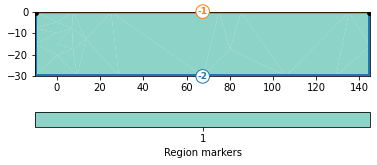

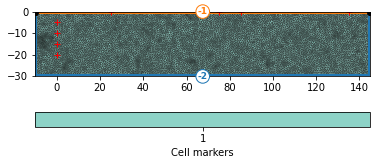

In [10]:
world = mt.createWorld(start=[min(pg.x(scheme))-10, 0], end=[max(pg.x(scheme))+10, -30], worldMarker=True, marker=1)
print(world)
for pos in scheme.sensors():
    world.createNode(pos, marker=-99)

print(world)
pg.show(world, markers=True)
mesh = mt.createMesh(world, area=.5, quality=34, smooth=[1, 10])
print(mesh, mesh.boundingBox())
for el in scheme.sensors():
    n = mesh.findNearestNode(el)
    npos = mesh.node(n).pos()
    print(el, npos, el.distance(npos))
    
ax, _ = pg.show(mesh, markers=True, showMesh=True);
ax.plot(pg.x(scheme), pg.y(scheme), "r+");

In [8]:
fop = ert.ERTModelling(verbose=False)
fop.setData(scheme)
fop.setMesh(mesh)
model = np.ones(mesh.cellCount())
fop.createJacobian(model)

01/12/22 - 13:23:00 - pyGIMLi - INFO - Found 1 regions.
01/12/22 - 13:23:00 - pyGIMLi - INFO - Creating forward mesh from region infos.
01/12/22 - 13:23:00 - pyGIMLi - INFO - Creating refined mesh (P2) to solve forward task.


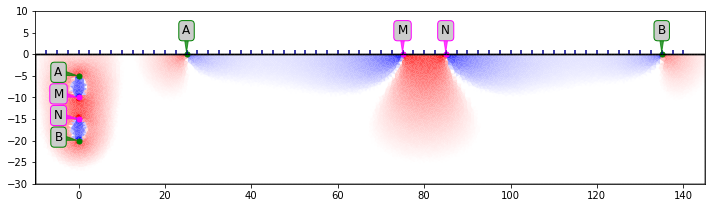

In [9]:
fig, ax = plt.subplots(figsize=(12, 8))
for i in range(2):
    sens = fop.jacobian()[i]
    normsens = pg.utils.logDropTol(sens/mesh.cellSizes(), 3e-4)
    normsens /= np.max(normsens)
    pg.show(mesh, normsens, ax=ax, cMap="bwr", colorBar=False,# ax=ax,
            label="sensitivity", nLevs=3, cMin=-1, cMax=1, coverage=np.abs(normsens)>0)
    plotABMN(ax, scheme, i, side=(i>0))

ax.set_ylim(-30, 10)
ax.vlines(np.arange(-7.5, 141, 2.5), 0, 1, colors="darkblue")